In [2]:
import pandas as pd
df = pd.read_excel(f"/home/u00232/dss/share24S/mizuho/20240522_課題データ/学習用データ/学習用マーケット・経済指標データ.xlsx",header=6, sheet_name=1)
adf =  pd.read_excel("/home/u00232/dss/share24S/mizuho/20240522_課題データ/テスト用データ/テスト用マーケット・経済指標データ.xlsx",header=6,  sheet_name=1)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import random

random.seed(3)
np.random.seed(4)
torch.manual_seed(5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 特徴量の選択はここを変える！

# df とadfの両方に適用する
# df['RiskIndex'] = df['something'] - df['something2']
# adf['RiskIndex'] = adf['something'] - adf['something2']

target = 'VIXIndex'
features = ['ESIndex', 'TYComdty', 'HIIndex', 'MXEFIndex']

tdf = df[['Dates'] + features+[target]].dropna()
tadf = adf[['Dates'] + features + [target]].dropna()




Using device: cuda


In [4]:

train_df = tdf
test_df = tadf

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features + [target]])
test_scaled = scaler.transform(test_df[features + [target]])

PREDICTION_DAYS = 11

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length - (PREDICTION_DAYS - 1)

    def __getitem__(self, index):
        return (self.data[index:index+self.seq_length, :-1], 
                self.data[index+self.seq_length+(PREDICTION_DAYS-1), -1])

seq_length = 30
train_dataset = TimeSeriesDataset(train_scaled, seq_length)
test_dataset = TimeSeriesDataset(test_scaled, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x[-1]
        return self.fc(x).squeeze()

input_dim = len(features)
model = TransformerModel(input_dim, d_model=64, nhead=4, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
predictions = []
with torch.no_grad():
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        output = model(batch_x).to("cpu")
        # VIX
        predictions.append(output.item())

test_features = test_df[features].values[seq_length:-(PREDICTION_DAYS-1)]
predictions_array = np.array(predictions).reshape(-1, 1)

assert len(test_features) == len(predictions_array), "Size mismatch between features and predictions"

predictions_unscaled = scaler.inverse_transform(
    np.column_stack([test_features, predictions_array]))[:, -1]



Epoch [1/5], Loss: 0.0096
Epoch [2/5], Loss: 0.0221
Epoch [3/5], Loss: 0.0035
Epoch [4/5], Loss: 0.0032
Epoch [5/5], Loss: 0.0095


In [43]:
def make_flag(predict_vix: np.ndarray):
    df = pd.DataFrame( {"flag_up": [0]*len(predict_vix), "flag_down": [0]*len(predict_vix)})
    for i,vix in enumerate(predict_vix):
        # 以下を書き換える
        if vix > 22:
            df.loc[i, "flag_up"] = 1
        if vix > 18:
            df.loc[i, "flag_down"] = 1
    return df

pred_flaged_df = make_flag(predictions_unscaled)

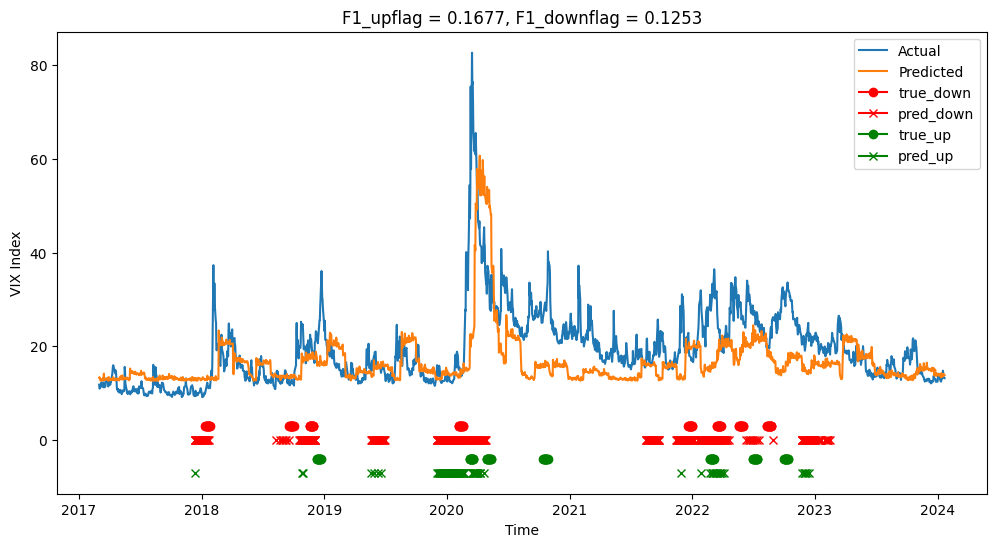

In [59]:
from sklearn.metrics import f1_score

def summary_f1score(df_true, df_pred):
    f1_inc = f1_score(df_true['flag_up'], df_pred['flag_up'])
    f1_dec = f1_score(df_true['flag_down'], df_pred['flag_down'])
    return f1_inc, f1_dec    


def visualize_flag(pred_fdf, pred_VIX=None, flag_marker_loc = 0):
    '''
    Argument:
        pred_fdf 予測したフラグDataframe, ['flagup', 'flag_down']列があれば良い
        pred_VIX(Optional) なくても良い．予測したVIXの結果．
        flag_marker_loc どこに上昇下落フラグを表示するか(高さ，yを指定できる)
    '''
    import matplotlib.pyplot as plt

    fdf = raw_fdf = pd.read_csv(
        "/home/u00232/dss/share24S/mizuho/20240522_課題データ/テスト用データ/テスト用正解ラベル.csv"
    )

    plt.figure(figsize=(12, 6))
    plt.plot(
        tadf["Dates"].tail(1752),
        test_df[target].values[seq_length + PREDICTION_DAYS - 1 :],
        label="Actual",
    )
    if pred_VIX is not None:
        plt.plot(
            tadf["Dates"].tail(1752),
            pred_VIX,
            label="Predicted",
        )
    fdf["Dates"] = pd.to_datetime(raw_fdf["Dates"])
    pred_fdf["Dates"] = fdf["Dates"]

    for index, row in fdf.iterrows():
        if row["flag_down"] == 1:
            plt.plot(row["Dates"], flag_marker_loc + 8, "o", color="red")
        if row["flag_up"] == 1:
            plt.plot(row["Dates"], flag_marker_loc + 1, "o", color="green")

    for index, row in pred_fdf.iterrows():
        if row["flag_down"] == 1:
            plt.plot(row["Dates"], flag_marker_loc + 5, "x", color="red")
        if row["flag_up"] == 1:
            plt.plot(row["Dates"], flag_marker_loc + -2, "x", color="green")

    plt.plot([], [], marker="o", color="red", label="true_down")
    plt.plot([], [], marker="x", color="red", label="pred_down")
    plt.plot([], [], marker="o", color="green", label="true_up")
    plt.plot([], [], marker="x", color="green", label="pred_up")

    plt.xlabel("Time")
    plt.ylabel("VIX Index")
    f1_inc, f1_dec = summary_f1score(fdf.tail(1752), pred_fdf)

    plt.title(f"F1_upflag = {f1_inc:.4f}, F1_downflag = {f1_dec:.4f}")
    plt.legend()
    plt.show()


visualize_flag(pred_flaged_df, predictions_unscaled, flag_marker_loc=-5)

上昇フラグf1値:   0.1677     TN:1599 FP:83 FN:56 TP:14
下落フラグf1値:   0.1253     TN:1318 FP:354 FN:51 TP:29
